<a href="https://colab.research.google.com/github/uervitonsantos/Atividade_Analise_Bayeseana_Com_RSTAN/blob/main/trabalho_de_estatistivca_bayesiana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rpy2==3.5.4

In [3]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("rstanarm")

In [64]:
%%R
library(ggplot2)
library(dplyr)
library(bayesplot)
library(rstanarm)
theme_set(bayesplot::theme_default())

In [65]:
%%R
df <- read.csv("/content/drive/MyDrive/Colab Notebooks/DateSet/Motor_Bomba.csv", header = TRUE, sep = ";", dec = ",")

In [66]:
%%R
str(df)

'data.frame':	363 obs. of  22 variables:
 $ Ano                            : int  2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 ...
 $ Dia                            : int  2 3 4 5 6 7 8 9 10 11 ...
 $ FALHA                          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Temp..Estator.Fase.U           : int  38 38 38 38 38 38 38 38 38 38 ...
 $ Temp..Estator.Fase.V           : int  40 40 40 40 40 40 40 40 40 40 ...
 $ Temp..Estator.Fase.WA          : int  37 37 37 37 37 37 37 36 36 36 ...
 $ Temp..Estator.Fase.WB          : int  39 39 39 39 39 39 39 39 39 39 ...
 $ Vibração.Bomba.LA              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Vazão.Bomba                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Corrente                       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pressão.Desc.                  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Pressão.Suc                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Posição.FCV                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Temp..externo.mancal.escora.LNA: int  2

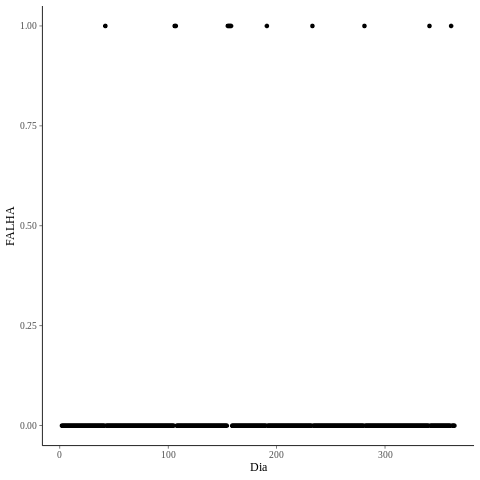

In [80]:
%%R
p <- ggplot(df, aes(Dia, FALHA)) + 
  geom_point()

  p

In [91]:
%%R
sd(df$FALHA) %>% log

[1] -1.720177


In [92]:
%%R
sd(df$Dia) %>% log

[1] 4.653325


In [93]:
%%R
sd(df$Temp..mancal.LA.motor) %>% log

[1] 2.052306


In [138]:
%%R
# Estimate Bayesian version with stan_glm
stan_glm1 <- stan_glm(formula = FALHA ~ Dia + Temp..Estator.Fase.U +
                      offset(log(Dia)),
                      data = df,  
                      family = poisson, 
                    #   prior = normal(c(0, 0, 0), c(0.1, 5, 5)),
                    #   prior_intercept = normal(0, 2.5)
                    )
summary(stan_glm1)


SAMPLING FOR MODEL 'count' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.68776 seconds (Warm-up)
Chain 1:                0.447674 seconds (Sampling)
Chain 1:                1.13